In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tifffile import imread
import matplotlib. pyplot as plt
import cv2

C:\Users\foresight\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\foresight\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\foresight\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape).T

def read_data(data):
    ## read img
    img_path= data['image_path']
    try: img= imread(img_path)
    except: img= np.array(Image.open(img_path))
    
    ## read mask
    mask= rle_decode(data['rle'], img.shape[:2])
    mask= np.expand_dims(mask, axis= 2)
    return img, mask

In [3]:
train_df= pd.read_csv('Data/train.csv')
ex_df= pd.read_csv('Data/train_ex.csv')
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex                    image_path  fold  
0    Male  Data/train_images/10044.tiff     3  
1    Male  Data/train_images/10274.tiff     3  
2    Male  Data/train_images/10392.tiff     4  
3    Male  Data/train_images/10488.tiff     4  
4  Female  Data/train_images/10610.tiff     1

# Oragn Distribution

<AxesSubplot:>

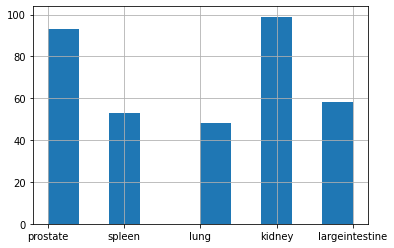

In [5]:
train_df['organ'].hist()

# Organ Sample

organ: prostate


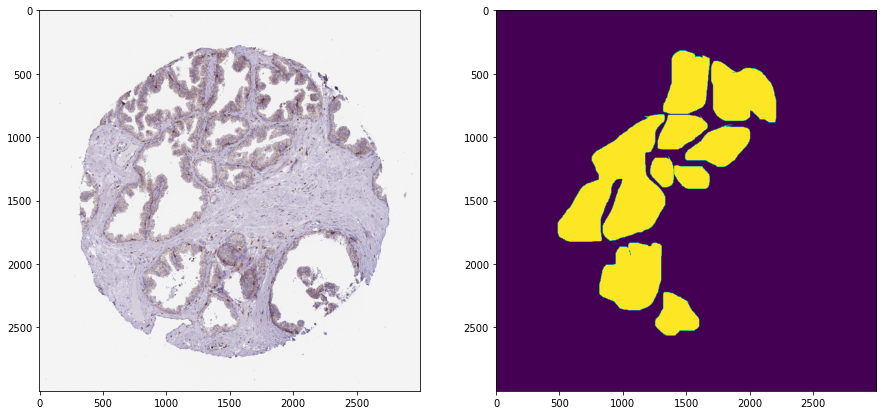

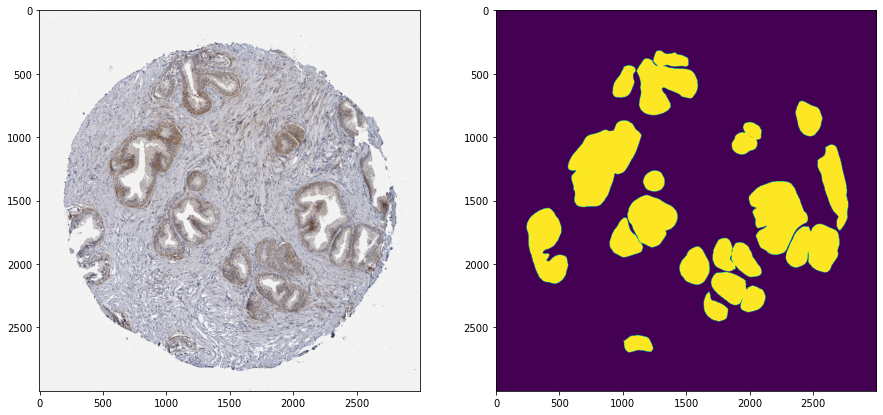

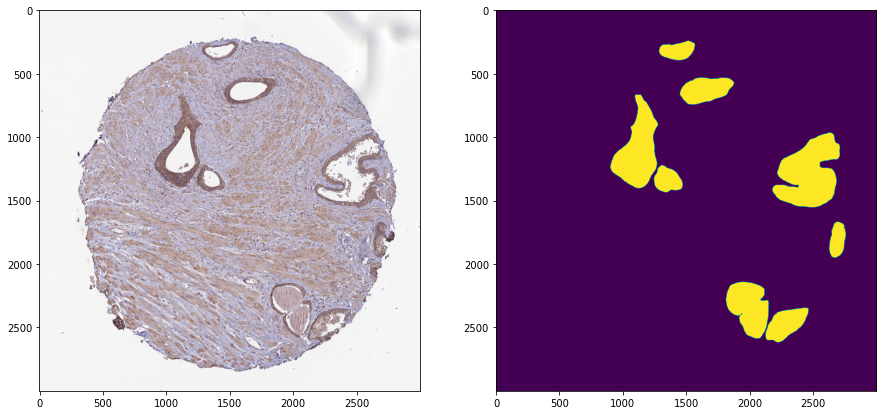

organ: spleen


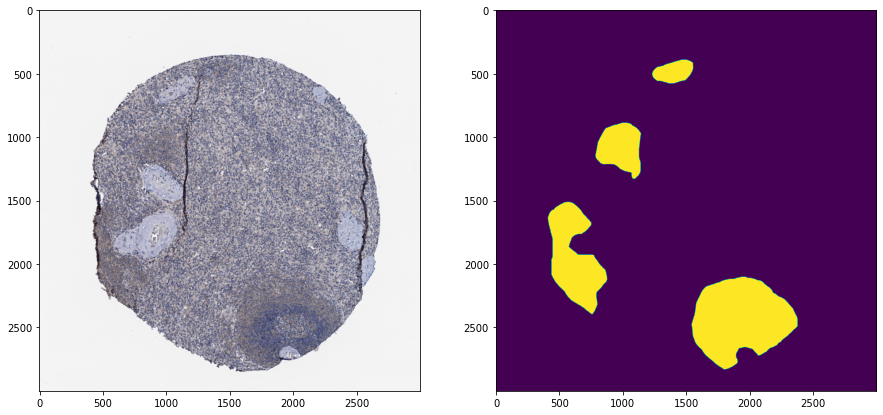

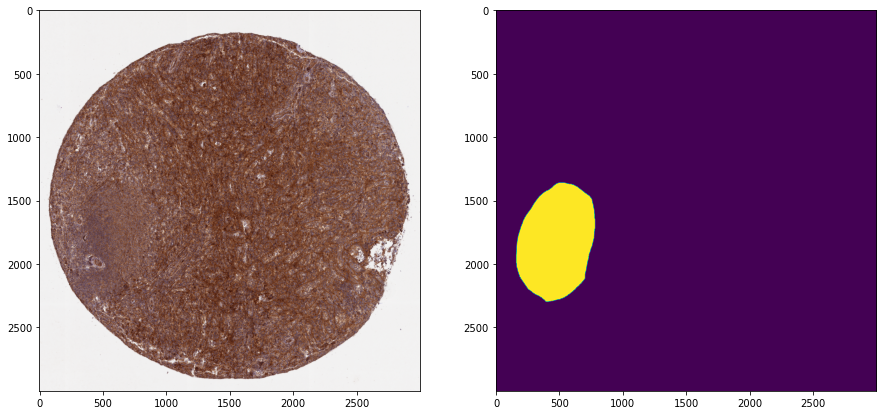

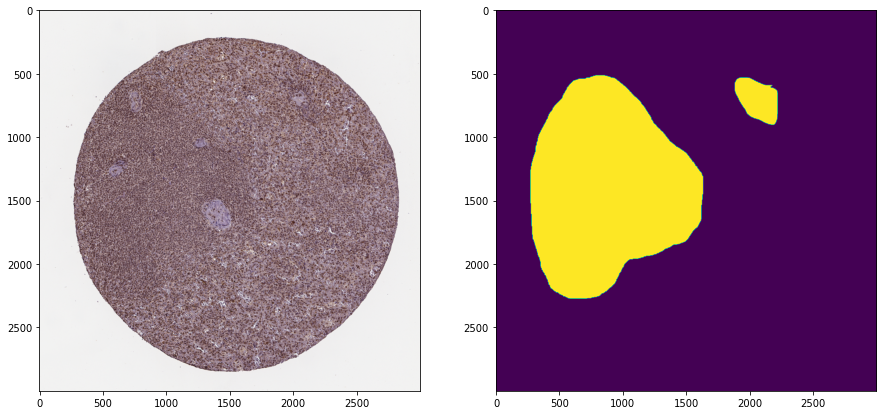

organ: lung


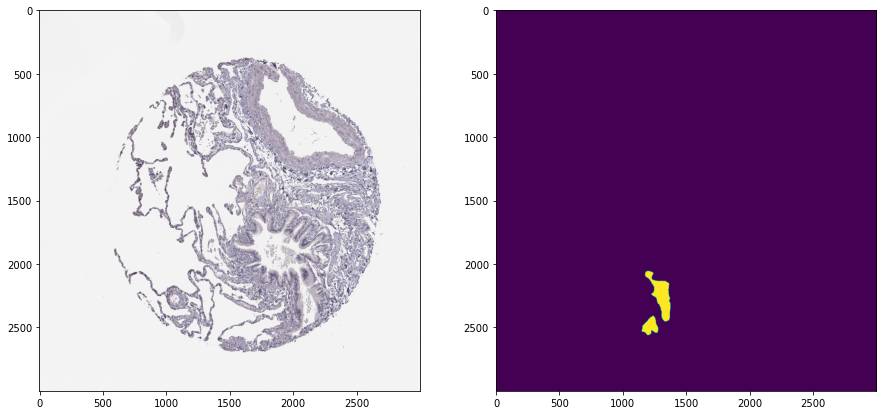

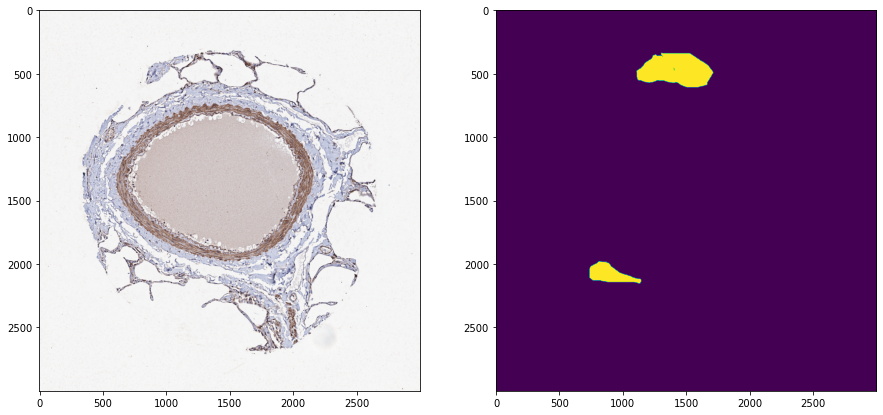

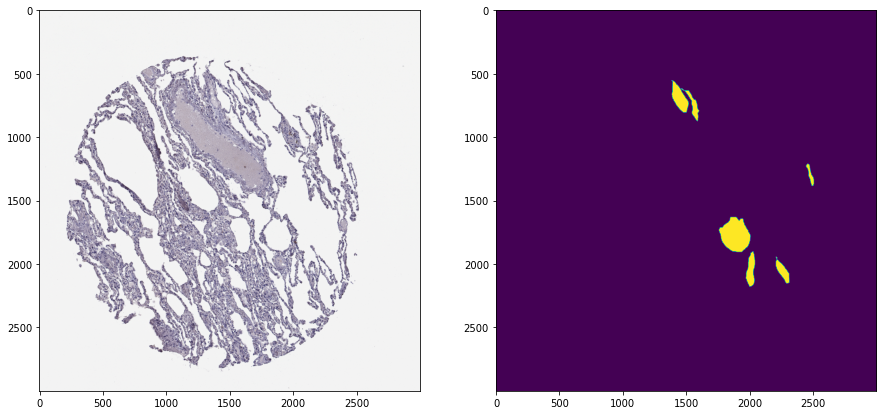

organ: kidney


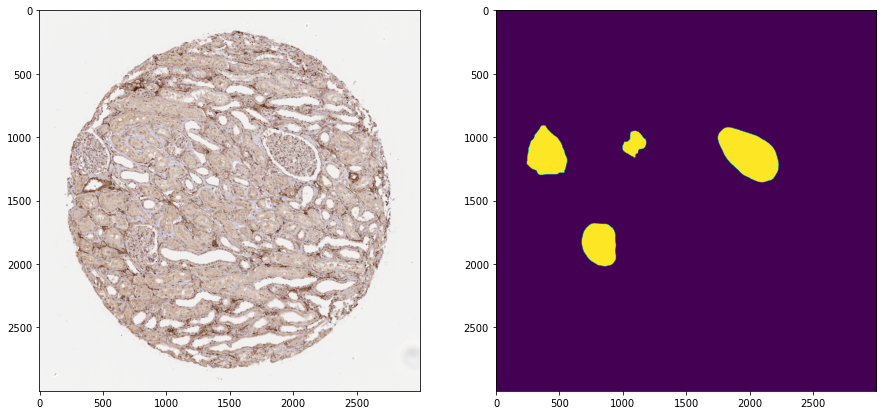

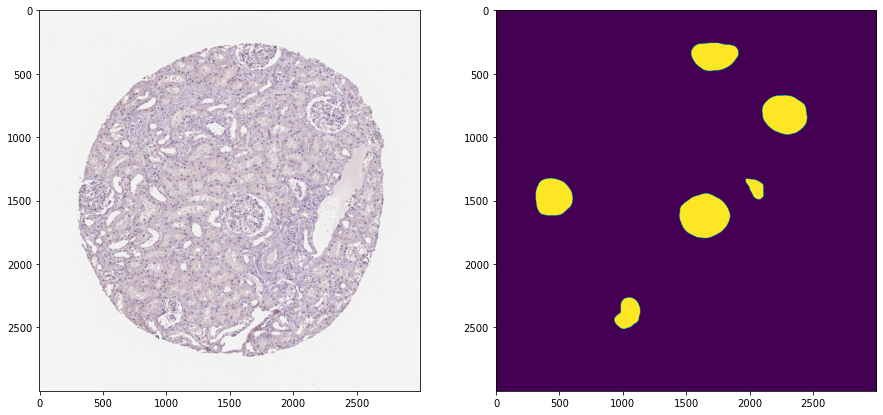

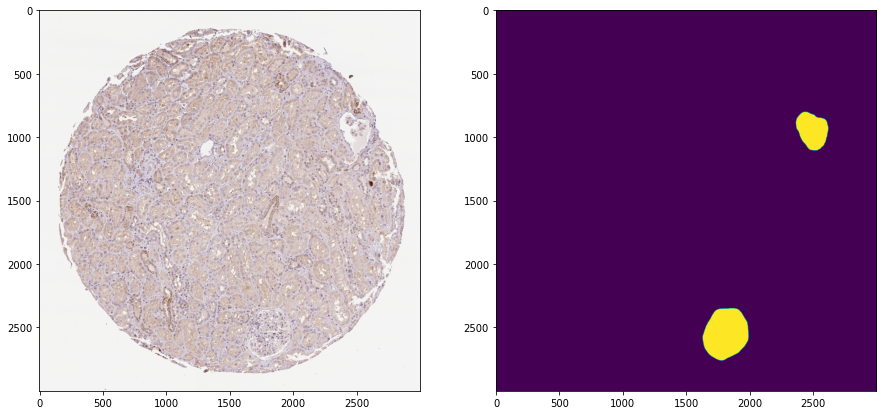

organ: largeintestine


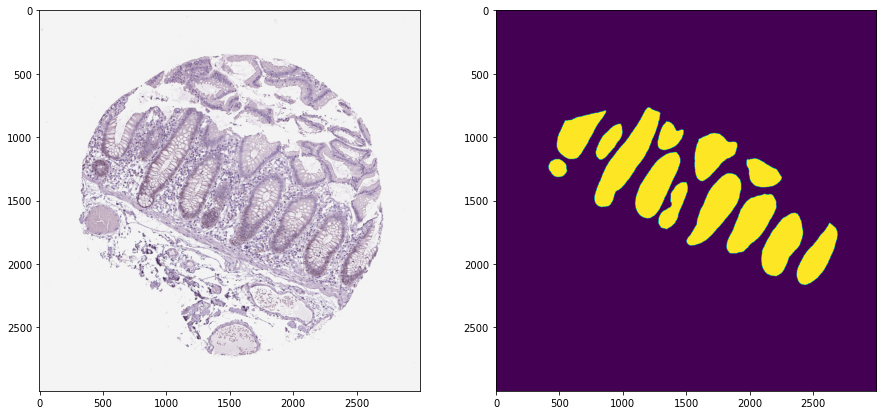

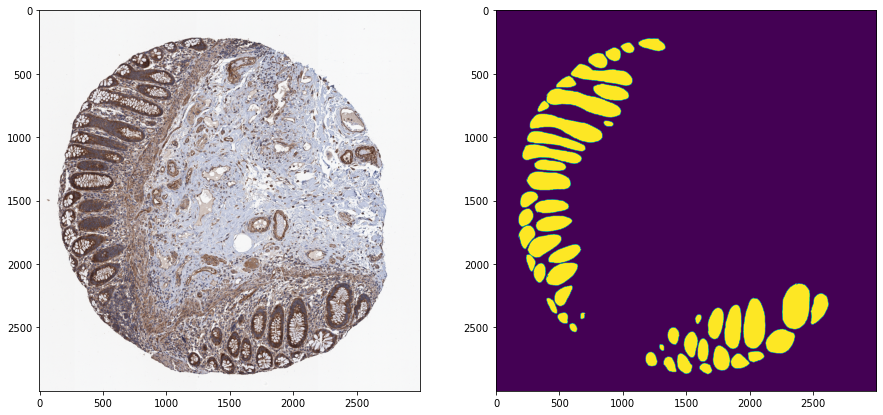

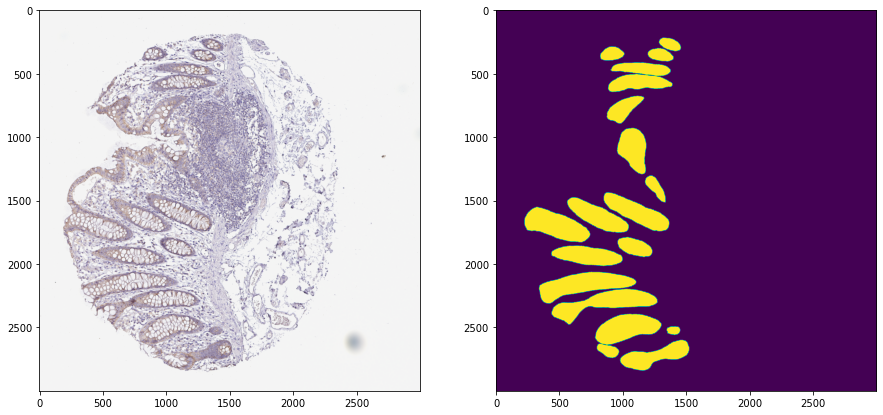

In [6]:
organs= train_df['organ'].unique().tolist()
for organ in organs:
    print(f'organ: {organ}')
    data= train_df[train_df['organ']==organ].reset_index(drop=True)
    for i in range(3):
        img, mask= read_data(data.loc[i])
        plt.figure(figsize=(15,15))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(mask)
        plt.show()

# Domain Shift

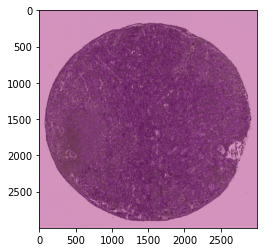

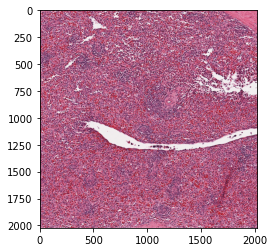

In [11]:
from skimage.measure import label, regionprops

def crop_target(img):
    """
    input: img np array
    output: biggest area bbox
    """
    def mask_to_bbox(mask):
        label_image = label(mask,connectivity=2)
        bbox= []
        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            bbox.append([minc, minr, maxc, maxr])
        return bbox
    
    mask= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, mask= cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask= np.asarray(mask, dtype= float)
    mask= 0-mask
    mask-= mask.min()
    mask= np.asarray(mask, dtype= int)
    bbox= np.array(mask_to_bbox(mask))
    area= (bbox[:,2]-bbox[:,0]) * (bbox[:,3]-bbox[:,1])
    indx= area.argmax()
    
    return bbox[indx]

def domain_shift(img):
    def shift_ms(img, mean, std):
        img_mean= img.mean()
        img_std= img.std()
        img= img-img_mean
        img/= img_std

        img*= std
        img+= mean
        return img
    
    h_m= np.random.choice(range(150, 170))
    h_s= np.random.choice(range(5, 20))
    s_m= np.random.choice(range(110, 130))
    s_s= np.random.choice(range(25, 65))
    v_m= np.random.choice(range(150, 190))
    v_s= np.random.choice(range(25, 60))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    hsv_img[...,0]= shift_ms(hsv_img[..., 0], h_m, h_s)
    hsv_img[...,1]= shift_ms(hsv_img[..., 1], s_m, s_s)
    hsv_img[...,2]= shift_ms(hsv_img[..., 2], v_m, v_s)
    
    return cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)


test_img= imread('Data/test_images/10078.tiff')
df= train_df[train_df['organ']=='spleen'].reset_index(drop=True)
train_img= imread(df.loc[1, 'image_path'])
train_img= domain_shift(train_img)

plt.imshow(train_img)
plt.show()
plt.imshow(test_img)
plt.show()

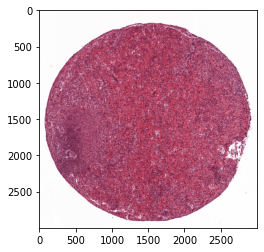

In [14]:
import staintools

target = staintools.read_image('Data/test_images/10078.tiff')
df= train_df[train_df['organ']=='spleen'].reset_index(drop=True)
to_transform = staintools.read_image(df.loc[1, 'image_path'])

# Standardize brightness (optional, can improve the tissue mask calculation)
target = staintools.LuminosityStandardizer.standardize(target)
to_transform = staintools.LuminosityStandardizer.standardize(to_transform)

# Stain normalize
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)
transformed1 = normalizer.transform(to_transform)
plt.imshow(transformed1)